In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
#view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create session from python to db
session = Session(engine)

# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation in Hawaii from 2016-08-23 to 2017-08-23')

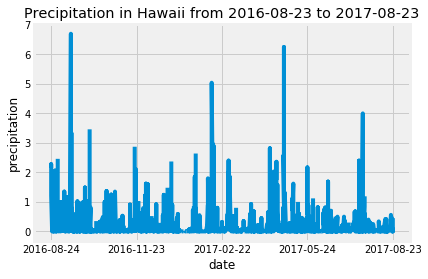

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0] #most recent date as str
max_date_dt = dt.datetime.strptime(max_date_str, '%Y-%m-%d').date() #convert to datetime to get year in next line
low_bound_dt = max_date_dt.replace(year=(max_date_dt.year - 1)) #date range is 1 year
low_bound_str = low_bound_dt.strftime('%Y-%m-%d') #get it back in ISO string format to use below

# Perform a query to retrieve the data and precipitation scores
results_1 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > low_bound_str) #nice

# Save the query results as a Pandas DataFrame and set the index to the date column
df_1 = pd.DataFrame(results_1, columns = ['date', 'prcp'])
df_1.set_index('date', inplace=True)

# Sort the dataframe by date
df_1.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df_1['prcp'])
plt.xlabel('date')
plt.ylabel('precipitation')
plt.xticks(np.arange(0,365,91))
plt.title(f'Precipitation in Hawaii from {low_bound_str} to {max_date_str}')

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_1.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
# Design a query to show how many stations are available in this dataset
num_stations = session.query(Measurement.station).distinct().count()
num_stations

9

In [11]:
# What are the most active stations? (i.e. what stations have the most rows?)
# List the stations and their measurement counts in descending order.
results_2 = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc())
for row in results_2:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature at most active station
station_id = results_2.first()[0] #most active station

#perform the query and print the first and only resultant row
print (session.query(Measurement.station,Station.name,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id, Measurement.station == Station.station).first())

('USC00519281', 'WAIHEE 837.5, HI US', 54.0, 85.0, 71.66378066378067)


Text(0.5, 1.0, 'Histogram of obs. temp. at station: USC00519281 \nFrom 2016-08-18 to 2017-08-18')

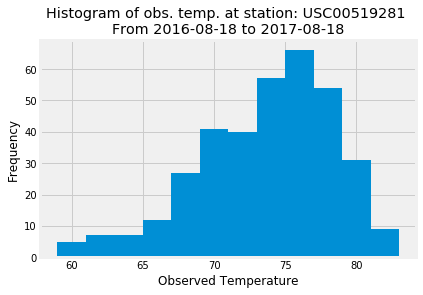

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#this will get the station id with the most number of temps read
most_temps_station_id = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).first()[0]


#query for most recent date for this station
max_date_temps_str = session.query(Measurement.date).\
    filter(Measurement.station == most_temps_station_id).\
    order_by(Measurement.date.desc()).first()[0]

#go back 12 months
max_date_temps_dt = dt.datetime.strptime(max_date_temps_str, '%Y-%m-%d').date() #convert to date time to get year below
low_bound_temps_dt = max_date_temps_dt.replace(year=(max_date_temps_dt.year - 1)) #get year, subtract by 1
low_bound_temps_str = low_bound_temps_dt.strftime('%Y-%m-%d') #get it back in string format to use below

#the query
results_3 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > low_bound_temps_str, Measurement.station == most_temps_station_id)

#put into data frame for procesing
df_2 = pd.DataFrame(results_3, columns = ['date', 'tobs'])
df_2.set_index('date', inplace=True)

#histogram
plt.hist(df_2['tobs'],bins=12)
plt.ylabel('Frequency')
plt.xlabel('Observed Temperature')
plt.title(f'Histogram of obs. temp. at station: {most_temps_station_id} \nFrom {low_bound_temps_str} to {max_date_temps_str}')